## KAUSHAL ATUL SORTE

### NUID : 002769107

In [245]:
from collections import namedtuple
import copy
import gymnasium as gym
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
import math
import random
import highway_env
from stable_baselines3 import DQN
import torch

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Environments

In this notebook, we will implement DQN and run it on four environments which have a continuous state-space and discrete action-space.

 * Cart Pole: Balance a pole on a moving cart (https://gymnasium.farama.org/environments/classic_control/cart_pole/)
 * Mountain Car: Gather momentum to climb a hill (https://gymnasium.farama.org/environments/classic_control/mountain_car/)
 * Acrobot: Swing a two-link robot and reach the area above a line (https://gymnasium.farama.org/environments/classic_control/acrobot/)
 * Lunar Lander: Fly and land a spaceship in the landing spot (https://gymnasium.farama.org/environments/box2d/lunar_lander/)

*Note: If you are having trouble loading Lunar Lander due to Box2D/SWIG issues, feel free to comment out the environment for now. It is possible to complete the assignment without using this environment, but it is a particularly fun domain if you can get it working.*

In [246]:
# Envs for training (no rendering)
envs = {
    'cartpole': gym.make('CartPole-v1'),
    'mountaincar': gym.make('MountainCar-v0'),
    'acrobot': gym.make('Acrobot-v1'),
}
# Envs for visualization
envs_vis = {
    'cartpole': gym.make('CartPole-v1', render_mode="human"),
    'mountaincar': gym.make('MountainCar-v0', render_mode="human"),
    'acrobot': gym.make('Acrobot-v1', render_mode="human"),
}

These environments are particularly nice because they all include a graphical visualization which we can use to visualize our learned policies. (V. Mnih: "Visualize everything you can think of.") Run the following cell and click the buttons to run the visualization with a random policy.

*Note: You may need to restart the kernel after rendering one episode. Also, the random policy often results in very fast termination in Cart Pole and Lunar Lander, so you may not be able to see the visualization.*

In [247]:
def render(env, policy=None):
    """Graphically render an episode using the given policy

    :param env: Gymnasium environment
    :param policy: Function which maps state to action.  If None, the random
                   policy is used.
    """

    if policy is None:
        # Random policy
        def policy(state):
            return env.action_space.sample()

    # Basic gym loop
    state, info = env.reset()
    while True:
        action = policy(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        if terminated or truncated:
            break
        state = next_state

## Part (a): Exponential $\varepsilon$-greedy decay

Instead of using a fixed value of $\varepsilon$, it is common to anneal $\varepsilon$ over time according to a schedule (such that initially almost all actions are exploratory). DQN used a linear decay schedule, but there we will use exponential decay, defined as:
$$\varepsilon_t = a \exp (b t)$$
where $a$ and $b$ are the parameters of the schedule. Beyond a specified number of time steps, $\varepsilon$ will be kept fixed at a small constant value to maintain continual exploration.

The interface to the scheduler receives the initial value, the final value, and in how many steps to go from initial to final. Your task is to compute parameters `a` and `b` to make the scheduler work as expected.

In [248]:
class ExponentialSchedule:
    def __init__(self, value_from, value_to, num_steps):
        """Exponential schedule from `value_from` to `value_to` in `num_steps` steps.

        :param value_from: Initial value
        :param value_to: Final value
        :param num_steps: Number of steps for the exponential schedule
        """
        self.value_from = value_from
        self.value_to = value_to
        self.num_steps = num_steps

        # Determine the `a` and `b` parameters such that the schedule is correct
        self.a = self.value_from
        self.b = (math.log(self.value_to/self.value_from))/(num_steps-1)

    def value(self, step) -> float:
        """Return exponentially interpolated value between `value_from` and `value_to` interpolated value between.

        Returns {
            `value_from`, if step == 0 or less
            `value_to`, if step == num_steps - 1 or more
            the exponential interpolation between `value_from` and `value_to`, if 0 <= steps < num_steps
        }

        :param step: The step at which to compute the interpolation
        :rtype: Float. The interpolated value
        """

        # Implement the schedule rule as described in the docstring,
        # using attributes `self.a` and `self.b`.
        if step < 0:
            return self.value_from

        if step >= self.num_steps - 1:
            return self.value_to

        if step >=0 and step<self.num_steps:
            return self.a*math.exp(self.b*step)


# DO NOT EDIT: Test code

def _test_schedule(schedule, step, value, ndigits=5):
    """Tests that the schedule returns the correct value."""
    v = schedule.value(step)
    if not round(v, ndigits) == round(value, ndigits):
        raise Exception(
            f'For step {step}, the scheduler returned {v} instead of {value}'
        )

_schedule = ExponentialSchedule(0.1, 0.2, 3)
_test_schedule(_schedule, -1, 0.1)
_test_schedule(_schedule, 0, 0.1)
_test_schedule(_schedule, 1, 0.141421356237309515)
_test_schedule(_schedule, 2, 0.2)
_test_schedule(_schedule, 3, 0.2)
del _schedule

_schedule = ExponentialSchedule(0.5, 0.1, 5)
_test_schedule(_schedule, -1, 0.5)
_test_schedule(_schedule, 0, 0.5)
_test_schedule(_schedule, 1, 0.33437015248821106)
_test_schedule(_schedule, 2, 0.22360679774997905)
_test_schedule(_schedule, 3, 0.14953487812212207)
_test_schedule(_schedule, 4, 0.1)
_test_schedule(_schedule, 5, 0.1)
del _schedule

## Part (b): Replay memory

Now we will implement the replay memory (also called the replay buffer), the data-structure where we store previous experiences so that we can re-sample and train on them.

In [249]:
# Batch namedtuple, i.e. a class which contains the given attributes
### PR CHANGE - Add indices field
Batch = namedtuple(
    'Batch', ('states', 'actions', 'rewards', 'next_states', 'dones', 'indices')
)


class ReplayMemory:
    def __init__(self, max_size, state_size):
        """Replay memory implemented as a circular buffer.

        Experiences will be removed in a FIFO manner after reaching maximum
        buffer size.

        Args:
            - max_size: Maximum size of the buffer
            - state_size: Size of the state-space features for the environment
        """
        # Maximum size of the replay buffer
        self.max_size = max_size
        self.state_size = state_size

        # Preallocating all the required memory, for speed concerns
        self.states = torch.empty((max_size, state_size))
        self.actions = torch.empty((max_size, 1), dtype=torch.long)
        self.rewards = torch.empty((max_size, 1))
        self.next_states = torch.empty((max_size, state_size))
        self.dones = torch.empty((max_size, 1), dtype=torch.bool)

        # Probability field
        self.probabilities = torch.empty((max_size, 1))

        # Priority field
        self.priorities = torch.empty((max_size, 1))

        # Weight field
        self.weights = torch.empty((max_size, 1))

        # Pointer to the current location in the circular buffer
        self.idx = 0
        # Indicates number of transitions currently stored in the buffer
        self.size = 0

        # self.batch = Batch()
        self.priorities_sum_alpha = 0
        self.priorities_max = 1
        self.weights_max = torch.tensor(1)

        self.alpha = 0.8
        self.alpha_decay_rate = 0.999
        # self.alpha_decay_rate = 1.0
        self.beta = 0.4
        self.beta_growth_rate = 1.001

        ## Should be a parameter
        self.compute_weights = True

    def add(self, state, action, reward, next_state, done):
        """Add a transition to the buffer.

        :param state: 1-D np.ndarray of state-features
        :param action: Integer action
        :param reward: Float reward
        :param next_state: 1-D np.ndarray of state-features
        :param done: Boolean value indicating the end of an episode
        """

        self.states[self.idx] = torch.as_tensor(state)
        self.actions[self.idx] = torch.as_tensor(action)
        self.rewards[self.idx] = torch.as_tensor(reward)
        self.next_states[self.idx] = torch.as_tensor(next_state)
        self.dones[self.idx] = torch.as_tensor(done)

        priority = self.priorities_max
        weight = self.weights_max
        self.priorities_sum_alpha += priority ** self.alpha
        probability = priority ** self.alpha / self.priorities_sum_alpha

        # Add probability, weight, and priority to the replay buffer at the index.
        self.probabilities[self.idx] = probability
        self.weights[self.idx] = weight
        self.priorities[self.idx] = priority

        # DO NOT EDIT
        # Circulate the pointer to the next position
        # This gets rid of old transitions in a FIFO manner.
        self.idx = (self.idx + 1) % self.max_size
        # Update the current buffer size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size) -> Batch:
        """Sample a batch of experiences.

        If the buffer contains less that `batch_size` transitions, sample all
        of them.

        :param batch_size: Number of transitions to sample
        :rtype: Batch
        """

        # Sample with probabilities rather than randomly.
        # Store probabilites for all transitions in the replay buffer.
        if self.size < batch_size:
            batch = Batch(
                self.states,
                self.actions,
                self.rewards,
                self.next_states,
                self.dones,
                np.arange(self.size)
            )
        else:
            numpy_probs = self.probabilities.numpy().flatten()
            sampled_indices = np.random.choice(
                self.size,
                batch_size,
                replace=False,
                p=numpy_probs/np.sum(numpy_probs)
                )


            batch = Batch(
                self.states[sampled_indices],
                self.actions[sampled_indices],
                self.rewards[sampled_indices],
                self.next_states[sampled_indices],
                self.dones[sampled_indices],
                sampled_indices
            )

        self.batch = batch
        return batch

    def populate(self, env, num_steps):
        """Populate this replay memory with `num_steps` from the random policy.

        :param env: Gymnasium environment
        :param num_steps: Number of steps to populate the replay memory
        """

        state, _ = env.reset()
        for i in range(num_steps):
            ########## CHANGES
            state_id = torch.tensor(state.flatten()).to(device)
            action = env.action_space.sample()
            # Take the selected action
            next_state, reward, done, _ , _= env.step(action)
            next_state_id = torch.tensor(next_state.flatten()).to(device)
            self.add(
                state=state_id,
                action=action,
                reward=reward,
                next_state=next_state_id,
                done=done
            )
            state = next_state
            if done:
                state, _ = env.reset()

    def update_parameters(self):
        self.alpha *= self.alpha_decay_rate
        self.beta *= self.beta_growth_rate
        if self.beta > 1:
            self.beta = 1

    def update_priorities(self, tds, indices):

        for td, index in zip(tds, indices):

            td = abs(td)

            # PARAMETERIZE THE 0.00001
            td += 0.00001
            N = self.size

            updated_priority = td
            # updated_priority = torch.tensor(updated_priority)
            updated_priority = torch.from_numpy(updated_priority)
            if updated_priority > self.priorities_max:
                self.priorities_max = updated_priority

            # Compute importance sampling weights
            if self.compute_weights:
                updated_weight = ((N * updated_priority)**(-self.beta))/self.weights_max
                if updated_weight > self.weights_max:
                    self.weights_max = updated_weight
            else:
                # updated_weight = torch.tensor(1)
                updated_weight = torch.tensor(1)

            # Get old priority value for this index
            old_priority = self.priorities[index]

            # Add new priority value and subtract old one.
            self.priorities_sum_alpha += updated_priority**self.alpha - old_priority**self.alpha
            updated_probability = td**self.alpha / self.priorities_sum_alpha

            # Multiply probabilities with weights.
            if self.compute_weights:
                updated_probability *= updated_weight

            # Add updated probability, weight and priority to the replay buffer.
            self.probabilities[index] = updated_probability
            self.weights[index] = updated_weight
            self.priorities[index] = updated_priority

## Part (c): Q-network

In this section, we define the object that DQN learns -- the Q-value neural network.

We use the PyTorch framework to define this neural network. PyTorch is a numeric computation library akin to NumPy, which also features automatic differentiation. This means that the library automatically computes the gradients for many differentiable operations, something we will exploit to train our models without having to manually program the gradients' code.
*Caveats: Sometimes we have to pay explicit attention to whether the operations we are using are implemented by the library (most are), and there are a number of operations which do not play well with automatic differentiation (most notably, in-place assignments).*

If you are unfamiliar with PyTorch, this will be a great opportunity to learn the basics. The official tutorials are a good start:\
https://pytorch.org/tutorials

Do not worry about learning the advanced details; the basics are enough. If you can understand the following MNIST code example and are able to run it yourself to train an MNIST digit classifier, you should know more than enough PyTorch to complete the assignment).\
https://github.com/pytorch/examples/blob/main/mnist/main.py

This library is a tool, and as many tools you will have to learn how to use it well. Sometimes not using it well means that your program will crash.  Sometimes it means that your program will not crash but will not be computing the correct outputs. And sometimes it means that it will compute the correct things, but is less efficient than it could otherwise be. This library is very popular these days, and online resources abound, so take your time to learn the basics. If you are having problems, first try to debug it yourself, and also look up the errors you get online. You can also use Piazza and office hours to ask for help with problems.

In the next cell, we inherit from the base class `torch.nn.Module` to implement our Q-network, which takes state-vectors and returns the respective action-values. Recall that the Q-network outputs the Q-values of **all** actions in the given input state.

In [250]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim, *, num_layers=5, hidden_dim=256):
        """Deep Q-Network PyTorch model.

        Args:
            - state_dim: Dimensionality of states
            - action_dim: Dimensionality of actions
            - num_layers: Number of total linear layers
            - hidden_dim: Number of neurons in the hidden layers
        """

        super().__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        # Define the layers of your model such that
        # * there are `num_layers` nn.Linear modules / layers
        # * all activations except the last should be ReLU activations
        #   (this can be achieved either using a nn.ReLU() object or the nn.functional.relu() method)
        # * the last activation can either be missing, or you can use nn.Identity()
        # Hint: A regular Python list of layers is tempting, but PyTorch does not register
        # these parameters in its computation graph. See nn.ModuleList or nn.Sequential

        layers = []
        layers.append(nn.Linear(state_dim, hidden_dim))
        layers.append(nn.ReLU())

        for i in range(num_layers - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(hidden_dim, action_dim))
        self.layers = nn.Sequential(*layers)


    def forward(self, states) -> torch.Tensor:
        """Q function mapping from states to action-values.

        :param states: (*, S) torch.Tensor where * is any number of additional
                dimensions, and S is the dimensionality of state-space
        :rtype: (*, A) torch.Tensor where * is the same number of additional
                dimensions as the `states`, and A is the dimensionality of the
                action-space. This represents the Q values Q(s, .)
        """
        # Use the defined layers and activations to compute
        # the action-values tensor associated with the input states.
        # Hint: Do not worry about the * arguments above (previous dims in tensor).
        # PyTorch functions typically handle those properly.
        return self.layers(states)

    # DO NOT EDIT: Utility methods for cloning and storing models.

    @classmethod
    def custom_load(cls, data):
        model = cls(*data['args'], **data['kwargs'])
        model.load_state_dict(data['state_dict'])
        return model

    def custom_dump(self):
        return {
            'args': (self.state_dim, self.action_dim),
            'kwargs': {
                'num_layers': self.num_layers,
                'hidden_dim': self.hidden_dim,
            },
            'state_dict': self.state_dict(),
        }


# DO NOT EDIT: Test code

def _test_dqn_forward(dqn_model, input_shape, output_shape):
    """Tests that the dqn returns the correctly shaped tensors."""
    inputs = torch.torch.randn((input_shape))
    outputs = dqn_model(inputs)

    if not isinstance(outputs, torch.FloatTensor):
        raise Exception(
            f'DQN.forward returned type {type(outputs)} instead of torch.Tensor'
        )

    if outputs.shape != output_shape:
        raise Exception(
            f'DQN.forward returned tensor with shape {outputs.shape} instead of {output_shape}'
        )

    if not outputs.requires_grad:
        raise Exception(
            f'DQN.forward returned tensor which does not require a gradient (but it should)'
        )

dqn_model = DQN(10, 4)
_test_dqn_forward(dqn_model, (64, 10), (64, 4))
_test_dqn_forward(dqn_model, (2, 3, 10), (2, 3, 4))
del dqn_model

dqn_model = DQN(64, 16)
_test_dqn_forward(dqn_model, (64, 64), (64, 16))
_test_dqn_forward(dqn_model, (2, 3, 64), (2, 3, 16))
del dqn_model

# Testing custom dump / load
dqn1 = DQN(10, 4, num_layers=10, hidden_dim=20)
dqn2 = DQN.custom_load(dqn1.custom_dump())
assert dqn2.state_dim == 10
assert dqn2.action_dim == 4
assert dqn2.num_layers == 10
assert dqn2.hidden_dim == 20

## Part (d): Single-batch update

Recall that the Q-network in DQN is trained periodically using batches of experiences sampled from the replay memory. The following function computes the loss on this batch (one-step TD errors, using the Q-network and the target network) and uses the optimizer to perform one step of gradient descent using the gradient of this loss with respect to the Q-network parameters (automatically, thanks to PyTorch!).

In [251]:
def train_dqn_batch(optimizer, batch, dqn_model, dqn_target, gamma, weights) -> float:
    """Perform a single batch-update step on the given DQN model.

    :param optimizer: nn.optim.Optimizer instance
    :param batch: Batch of experiences (class defined earlier)
    :param dqn_model: The DQN model to be trained
    :param dqn_target: The target DQN model, ~NOT~ to be trained
    :param gamma: The discount factor
    :param memory: weights
    :rtype: Float. The scalar loss associated with this batch
    """
    # YOUR CODE HERE: Compute the values and target_values tensors using the
    # given models and the batch of data.
    # Recall that 'Batch' is a named tuple consisting of
    # ('states', 'actions', 'rewards', 'next_states', 'dones')
    # Hint: Remember that we should not pass gradients through the target network

    batch_states = batch.states
    batch_actions = batch.actions
    values = dqn_model(batch_states.to(device))
    print(f'values raw shape {values.shape}')   # should be 5x5

    # Gets q values for the batch of states for the specified action indices
    values = values.gather(dim=1, index=batch_actions.to(device))   # Should be 5x1
    print(f'values for select actions shape {values.shape}')
    print(f'batch_actions = {batch_actions} batch actions shape = {batch_actions.shape}')   # 5 x 1

    # Get Q values for the batch of next states using the Value Network.
    q_values_next_states_value_net = dqn_model(batch.next_states.to(device))
    print(f'q values next raw shape {q_values_next_states_value_net.shape}')
    # print(f'q_values_next_states_value_net shape = {q_values_next_states_value_net.shape}')
    # print(f'q_values_next_states_value_net = {q_values_next_states_value_net}')

    # Get actions with max q for the next state.
    # actions_next_states  = (torch.argmax(q_values_next_states_value_net, dim=1)[0].detach().cpu())
    actions_next_states = torch.argmax(q_values_next_states_value_net, dim=1)
    actions_next_states = actions_next_states.unsqueeze(dim=1).detach().cpu()   # 5x1
    # print(f'actions_next_states shape = {actions_next_states.shape}')

    # actions_s1_trial = torch.argmax(q_values_next_states_value_net, dim=1)
    # print(f'actions_s1_trial = {actions_s1_trial} shape = {actions_s1_trial.shape}')

    # Get Q values for next states using target network.
    all_q_values_next_states = dqn_target(batch.next_states)
    print(f' All q values next state from target network shape {all_q_values_next_states.shape}')

    # Get the Q values pertaining to the max actions for next states.
    # print(f'q_values_next_states device = {q_values_next_states.device.type}')
    # print(f'all_q_values_next_states device = {all_q_values_next_states.device.type}')
    # print(f'actions_next_states device = {actions_next_states.device.type}')
    # print(f'Shape of actions_next_states = {actions_next_states.shape}')
    q_values_next_states = all_q_values_next_states.gather(dim=1, index=actions_next_states)
    print(f'q_values next states for actions shape {q_values_next_states.shape}')

    for i in range(len(batch.dones)):
        if batch.dones[i]:
            q_values_next_states[i] = 0

    # q_values_next_states = torch.unsqueeze(q_values_next_states, dim=1)
    target_values = (batch.rewards + gamma*q_values_next_states).detach()

    # print(f'target values shape {target_values.shape} {target_values}')
    # print(f'values shape {values.shape} {values}')

    # DO NOT EDIT

    assert (
        values.shape == target_values.shape
    ), 'Shapes of values tensor and target_values tensor do not match.'

    # Testing that the values tensor requires a gradient,
    # and the target_values tensor does not
    assert values.requires_grad, 'values tensor requires gradients'
    assert (
        not target_values.requires_grad
    ), 'target_values tensor should not require gradients'

    # Computing the scalar MSE loss between computed values and the TD-target
    # DQN originally used Huber loss, which is less sensitive to outliers
    values, target_values = values.to(device), target_values.to(device)
    loss = F.mse_loss(values, target_values)

    optimizer.zero_grad()  # Reset all previous gradients
    loss.backward()  # Compute new gradients
    optimizer.step()  # Perform one gradient-descent step

    ## PR CHANGE
    td_errors = (target_values - values).cpu()
    td_errors = td_errors.detach().numpy()
    return loss.item(), td_errors

## Part (e): DQN training loop

This is the main training loop for DQN. Please refer to Algorithm 1 in the DQN paper (reproduced in lecture slides).

In [252]:
def train_dqn(
    env,
    num_steps,
    *,
    num_saves=5,
    replay_size,
    replay_prepopulate_steps=0,
    batch_size,
    exploration,
    gamma,
):
    """
    DQN algorithm.

    Compared to previous training procedures, we will train for a given number
    of time-steps rather than a given number of episodes. The number of
    time-steps will be in the range of millions, which still results in many
    episodes being executed.

    Args:
        - env: The Gymnasium environment
        - num_steps: Total number of steps to be used for training
        - num_saves: How many models to save to analyze the training progress
        - replay_size: Maximum size of the ReplayMemory
        - replay_prepopulate_steps: Number of steps with which to prepopulate
                                    the memory
        - batch_size: Number of experiences in a batch
        - exploration: An ExponentialSchedule
        - gamma: The discount factor

    Returns: (saved_models, returns)
        - saved_models: Dictionary whose values are trained DQN models
        - returns: Numpy array containing the return of each training episode
        - lengths: Numpy array containing the length of each training episode
        - losses: Numpy array containing the loss of each training batch
    """

    ########################## CHANGES
    state_size = 25
    action_size = 5
    # Initialize the DQN and DQN-target models
    dqn_model = DQN(state_size, action_size).to(device)
    dqn_target = DQN.custom_load(dqn_model.custom_dump())

    # Initialize the optimizer
    ######## PARAMETERIZE LEARNING RATE HERE
    optimizer = torch.optim.Adam(dqn_model.parameters(), lr=1e-3)

    # Initialize the replay memory and prepopulate it
    memory = ReplayMemory(replay_size, state_size)
    print(env, replay_prepopulate_steps)
    memory.populate(env, replay_prepopulate_steps)

    # Initialize lists to store returns, lengths, and losses
    rewards = []
    returns = []
    lengths = []
    losses = []

    # Initialize structures to store the models at different stages of training
    t_saves = np.linspace(0, num_steps, num_saves - 1, endpoint=False)
    saved_models = {}

    i_episode = 0  # Use this to indicate the index of the current episode
    t_episode = 0  # Use this to indicate the time-step inside current episode

    state, _ = env.reset()  # Initialize state of first episode

    # Iterate for a total of `num_steps` steps
    pbar = tqdm.trange(num_steps)
    for t_total in pbar:
        # Use t_total to indicate the time-step from the beginning of training

        # Save model
        if t_total in t_saves:
            model_name = f'{100 * t_total / num_steps:04.1f}'.replace('.', '_')
            saved_models[model_name] = copy.deepcopy(dqn_model)

        epsilon = exploration.value(t_total)


        # Convert state to a 25x1 vector
        ########################CHANGES
        state_id = torch.tensor(state.flatten()).to(device)

        q_values = (dqn_model(state_id)).to(device)
        q_values_cpu = q_values.cpu()

        # if random.random() > epsilon:
        if random.random() > 0.0:
            action = np.argmax(q_values_cpu.detach().numpy())
        else:
            action = env.action_space.sample()

        next_state, reward, done, truncated, _ = env.step(action)

        #############CHANGES
        # next_state = torch.tensor(next_state).detach()
        next_state_id = torch.tensor(next_state.flatten()).to(device)
        memory.add(state_id, action, reward, next_state_id, done)
        rewards.append(reward)
        # YOUR CODE HERE: Once every 4 steps,
        #  * sample a batch from the replay memory
        #  * perform a batch update (use the train_dqn_batch() method)

        ############## PARAMETERIZE TRAINING FREQ
        if t_total%4 == 3:
        # if t_total%2 == 1:
            sample_batch = memory.sample(batch_size=batch_size)
            loss, td_errors = train_dqn_batch(
                optimizer=optimizer,
                batch=sample_batch,
                dqn_model=dqn_model,
                dqn_target=dqn_target,
                gamma=gamma,
                weights = memory.weights)
            losses.append(loss)
            memory.update_priorities(td_errors, sample_batch.indices)

        ################# PARAMETERIZE TARGET UPDATE INTERVAL ######################
        if t_total%50 == 49:
            dqn_target.load_state_dict(dqn_model.state_dict())

        # Updating replay memory parameters
        if t_total%500 == 499:
            memory.update_parameters()

        if done or truncated:
            # Anything you need to do at the end of an episode,
            # e.g., compute return G, store returns/lengths,
            # reset variables, indices, lists, etc.

            state, _ = env.reset()
            i_episode += 1
            t_episode = 0

            lengths.append(len(rewards))

            # Calculate Returns
            G = 0
            for r in rewards:
                G = r + gamma * G
            returns.append(G)

            rewards = []

            pbar.set_description(
                f'Episode: {i_episode} | Steps: {t_episode + 1} | Return: {G:5.2f} | Epsilon: {epsilon:4.2f}'
            )

        else:
            # Anything you need to do within an episode
            state = next_state
            t_episode += 1

    saved_models['100_0'] = copy.deepcopy(dqn_model)

    return (
        saved_models,
        np.array(returns),
        np.array(lengths),
        np.array(losses),
    )

## Part (f): Evaluation of DQN on the 4 environments

In the following section, run DQN on some/all of the 4 environments loaded in the beginning of this notebook (Cart Pole, Mountain Car, Acrobot, Lunar Lander).

Each trial (in each environment) is trained for 1.5 million steps, which takes substantially longer than previous assignments, estimated to be around 1-2 hours on a typical desktop/laptop CPU. Because of this, we only expect you to train for one trial in each environment. Additionally, it is fine to only evaluate a minimum of 2 out of the 4 environments, although we recommend trying all 4 (and/or multiple trials) if you are able to.

Since there is only one trial, we cannot obtain meaningful averages / confidence bands as in past assignments. Instead, we will just apply a moving average to smooth out the data in our graphs (you should plot both the raw data and the moving average).

Obviously, during development and debugging, you should set the number of training steps (and possibly other hyperparameters) to be much lower. However, please remember to restore the original values when you perform the final evaluation. Also, different environments train at different speeds -- be cognizant of this when choosing an environment to develop in (e.g., Mountain car is designed as a hard exploration problem). We recommending starting in Cart Pole because it is an easier problem and the environment runs faster. For reference, we can run this environment at ~650 steps/s = 40K steps/min, and it usually takes 2000-4000 episodes = ~100K steps (with the default exponential schedule) to see some initial signs of learning.

In [253]:
def moving_average(data, *, window_size = 50):
    """Smooths 1-D data array using a moving average.

    Args:
        data: 1-D numpy.array
        window_size: Size of the smoothing window

    Returns:
        smooth_data: A 1-d numpy.array with the same size as data
    """
    assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(
        np.ones_like(data), kernel
    )
    return smooth_data[: -window_size + 1]

### HIGHWAY ENVIRONMENT

In [254]:
env = gym.make('highway-fast-v0', render_mode='rgb_array')

env.default_config()
gamma = 0.99

# We train for many time-steps; as usual, you can decrease this during development / debugging,
# but make sure to restore it to 1_500_000 before submitting
# num_steps = 200000
# num_steps = 20000
num_steps = 100
num_saves = 5  # Save models at 0%, 25%, 50%, 75% and 100% of training

# replay_size = 15000
# replay_size = 200
replay_size = 10

# replay_prepopulate_steps = 200
replay_prepopulate_steps = 10

# batch_size = 64
batch_size = 5
exploration = ExponentialSchedule(value_from=1.0, value_to=0.005, num_steps=0.5*num_steps)
dqn_models_highway, returns_hw, lengths_hw, losses_hw = train_dqn(
    env,
    num_steps,
    num_saves=num_saves,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,
    gamma=gamma,
)

assert len(dqn_models_highway) == num_saves
assert all(isinstance(value, DQN) for value in dqn_models_highway.values())

# Saving computed models to disk, so that we can load and visualize them later
checkpoint = {key: dqn.custom_dump() for key, dqn in dqn_models_highway.items()}
torch.save(checkpoint, f'checkpoint_{env.spec.id}.pt')
np.save('returns_hwy_dqn_PER_DDQN.npy', returns_hw)
np.save('losses_hwy_dqn_PER_DDQN.npy', losses_hw)
np.save('lengths_hwy_dqn_PER_DDQN.npy', lengths_hw)

/home/kaushal/.local/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.default_config to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.default_config` for environment variables or `env.get_wrapper_attr('default_config')` that will search the reminding wrappers.
  logger.warn(


<OrderEnforcing<PassiveEnvChecker<HighwayEnvFast<highway-fast-v0>>>> 10


Episode: 1 | Steps: 1 | Return:  8.08 | Epsilon: 0.38:   9%|▉         | 9/100 [00:00<00:02, 36.54it/s]

values raw shape torch.Size([5, 5])
values for select actions shape torch.Size([5, 1])
batch_actions = tensor([[3],
        [1],
        [3],
        [3],
        [0]]) batch actions shape = torch.Size([5, 1])
q values next raw shape torch.Size([5, 5])
 All q values next state from target network shape torch.Size([5, 5])
q_values next states for actions shape torch.Size([5, 1])
values raw shape torch.Size([5, 5])
values for select actions shape torch.Size([5, 1])
batch_actions = tensor([[3],
        [3],
        [3],
        [3],
        [3]]) batch actions shape = torch.Size([5, 1])
q values next raw shape torch.Size([5, 5])
 All q values next state from target network shape torch.Size([5, 5])
q_values next states for actions shape torch.Size([5, 1])


Episode: 2 | Steps: 1 | Return:  2.72 | Epsilon: 0.25:  17%|█▋        | 17/100 [00:00<00:02, 34.82it/s]

values raw shape torch.Size([5, 5])
values for select actions shape torch.Size([5, 1])
batch_actions = tensor([[3],
        [3],
        [3],
        [3],
        [3]]) batch actions shape = torch.Size([5, 1])
q values next raw shape torch.Size([5, 5])
 All q values next state from target network shape torch.Size([5, 5])
q_values next states for actions shape torch.Size([5, 1])
values raw shape torch.Size([5, 5])
values for select actions shape torch.Size([5, 1])
batch_actions = tensor([[3],
        [3],
        [3],
        [3],
        [3]]) batch actions shape = torch.Size([5, 1])
q values next raw shape torch.Size([5, 5])
 All q values next state from target network shape torch.Size([5, 5])
q_values next states for actions shape torch.Size([5, 1])


Episode: 4 | Steps: 1 | Return:  5.17 | Epsilon: 0.07:  25%|██▌       | 25/100 [00:00<00:02, 33.75it/s]

values raw shape torch.Size([5, 5])
values for select actions shape torch.Size([5, 1])
batch_actions = tensor([[3],
        [3],
        [3],
        [3],
        [3]]) batch actions shape = torch.Size([5, 1])
q values next raw shape torch.Size([5, 5])
 All q values next state from target network shape torch.Size([5, 5])
q_values next states for actions shape torch.Size([5, 1])
values raw shape torch.Size([5, 5])
values for select actions shape torch.Size([5, 1])
batch_actions = tensor([[3],
        [3],
        [3],
        [3],
        [3]]) batch actions shape = torch.Size([5, 1])
q values next raw shape torch.Size([5, 5])
 All q values next state from target network shape torch.Size([5, 5])
q_values next states for actions shape torch.Size([5, 1])


Episode: 4 | Steps: 1 | Return:  5.17 | Epsilon: 0.07:  33%|███▎      | 33/100 [00:00<00:01, 35.19it/s]

values raw shape torch.Size([5, 5])
values for select actions shape torch.Size([5, 1])
batch_actions = tensor([[3],
        [3],
        [3],
        [3],
        [3]]) batch actions shape = torch.Size([5, 1])
q values next raw shape torch.Size([5, 5])
 All q values next state from target network shape torch.Size([5, 5])
q_values next states for actions shape torch.Size([5, 1])
values raw shape torch.Size([5, 5])
values for select actions shape torch.Size([5, 1])
batch_actions = tensor([[3],
        [3],
        [3],
        [3],
        [3]]) batch actions shape = torch.Size([5, 1])
q values next raw shape torch.Size([5, 5])
 All q values next state from target network shape torch.Size([5, 5])
q_values next states for actions shape torch.Size([5, 1])


Episode: 6 | Steps: 1 | Return:  2.02 | Epsilon: 0.02:  41%|████      | 41/100 [00:01<00:01, 34.99it/s]

values raw shape torch.Size([5, 5])
values for select actions shape torch.Size([5, 1])
batch_actions = tensor([[3],
        [3],
        [3],
        [3],
        [3]]) batch actions shape = torch.Size([5, 1])
q values next raw shape torch.Size([5, 5])
 All q values next state from target network shape torch.Size([5, 5])
q_values next states for actions shape torch.Size([5, 1])
values raw shape torch.Size([5, 5])
values for select actions shape torch.Size([5, 1])
batch_actions = tensor([[3],
        [3],
        [3],
        [3],
        [3]]) batch actions shape = torch.Size([5, 1])
q values next raw shape torch.Size([5, 5])
 All q values next state from target network shape torch.Size([5, 5])
q_values next states for actions shape torch.Size([5, 1])


Episode: 7 | Steps: 1 | Return:  9.51 | Epsilon: 0.01:  49%|████▉     | 49/100 [00:01<00:01, 36.00it/s]

values raw shape torch.Size([5, 5])
values for select actions shape torch.Size([5, 1])
batch_actions = tensor([[3],
        [3],
        [3],
        [3],
        [3]]) batch actions shape = torch.Size([5, 1])
q values next raw shape torch.Size([5, 5])
 All q values next state from target network shape torch.Size([5, 5])
q_values next states for actions shape torch.Size([5, 1])
values raw shape torch.Size([5, 5])
values for select actions shape torch.Size([5, 1])
batch_actions = tensor([[3],
        [3],
        [3],
        [3],
        [3]]) batch actions shape = torch.Size([5, 1])
q values next raw shape torch.Size([5, 5])
 All q values next state from target network shape torch.Size([5, 5])
q_values next states for actions shape torch.Size([5, 1])


Episode: 7 | Steps: 1 | Return:  9.51 | Epsilon: 0.01:  57%|█████▋    | 57/100 [00:01<00:01, 35.63it/s]

values raw shape torch.Size([5, 5])
values for select actions shape torch.Size([5, 1])
batch_actions = tensor([[3],
        [3],
        [3],
        [3],
        [3]]) batch actions shape = torch.Size([5, 1])
q values next raw shape torch.Size([5, 5])
 All q values next state from target network shape torch.Size([5, 5])
q_values next states for actions shape torch.Size([5, 1])
values raw shape torch.Size([5, 5])
values for select actions shape torch.Size([5, 1])
batch_actions = tensor([[3],
        [3],
        [3],
        [3],
        [3]]) batch actions shape = torch.Size([5, 1])
q values next raw shape torch.Size([5, 5])
 All q values next state from target network shape torch.Size([5, 5])
q_values next states for actions shape torch.Size([5, 1])


Episode: 8 | Steps: 1 | Return:  9.27 | Epsilon: 0.01:  66%|██████▌   | 66/100 [00:01<00:00, 36.58it/s]

values raw shape torch.Size([5, 5])
values for select actions shape torch.Size([5, 1])
batch_actions = tensor([[3],
        [3],
        [3],
        [3],
        [3]]) batch actions shape = torch.Size([5, 1])
q values next raw shape torch.Size([5, 5])
 All q values next state from target network shape torch.Size([5, 5])
q_values next states for actions shape torch.Size([5, 1])
values raw shape torch.Size([5, 5])
values for select actions shape torch.Size([5, 1])
batch_actions = tensor([[3],
        [3],
        [3],
        [3],
        [3]]) batch actions shape = torch.Size([5, 1])
q values next raw shape torch.Size([5, 5])
 All q values next state from target network shape torch.Size([5, 5])
q_values next states for actions shape torch.Size([5, 1])


Episode: 9 | Steps: 1 | Return:  8.29 | Epsilon: 0.01:  74%|███████▍  | 74/100 [00:02<00:00, 34.34it/s]

values raw shape torch.Size([5, 5])
values for select actions shape torch.Size([5, 1])
batch_actions = tensor([[3],
        [3],
        [3],
        [3],
        [3]]) batch actions shape = torch.Size([5, 1])
q values next raw shape torch.Size([5, 5])
 All q values next state from target network shape torch.Size([5, 5])
q_values next states for actions shape torch.Size([5, 1])
values raw shape torch.Size([5, 5])
values for select actions shape torch.Size([5, 1])
batch_actions = tensor([[3],
        [3],
        [3],
        [3],
        [3]]) batch actions shape = torch.Size([5, 1])
q values next raw shape torch.Size([5, 5])
 All q values next state from target network shape torch.Size([5, 5])
q_values next states for actions shape torch.Size([5, 1])


Episode: 10 | Steps: 1 | Return:  6.52 | Epsilon: 0.01:  82%|████████▏ | 82/100 [00:02<00:00, 35.17it/s]

values raw shape torch.Size([5, 5])
values for select actions shape torch.Size([5, 1])
batch_actions = tensor([[3],
        [3],
        [3],
        [3],
        [3]]) batch actions shape = torch.Size([5, 1])
q values next raw shape torch.Size([5, 5])
 All q values next state from target network shape torch.Size([5, 5])
q_values next states for actions shape torch.Size([5, 1])
values raw shape torch.Size([5, 5])
values for select actions shape torch.Size([5, 1])
batch_actions = tensor([[3],
        [3],
        [3],
        [3],
        [3]]) batch actions shape = torch.Size([5, 1])
q values next raw shape torch.Size([5, 5])
 All q values next state from target network shape torch.Size([5, 5])
q_values next states for actions shape torch.Size([5, 1])


Episode: 11 | Steps: 1 | Return:  6.36 | Epsilon: 0.01:  90%|█████████ | 90/100 [00:02<00:00, 36.07it/s]

values raw shape torch.Size([5, 5])
values for select actions shape torch.Size([5, 1])
batch_actions = tensor([[3],
        [3],
        [3],
        [3],
        [3]]) batch actions shape = torch.Size([5, 1])
q values next raw shape torch.Size([5, 5])
 All q values next state from target network shape torch.Size([5, 5])
q_values next states for actions shape torch.Size([5, 1])
values raw shape torch.Size([5, 5])
values for select actions shape torch.Size([5, 1])
batch_actions = tensor([[3],
        [3],
        [3],
        [3],
        [3]]) batch actions shape = torch.Size([5, 1])
q values next raw shape torch.Size([5, 5])
 All q values next state from target network shape torch.Size([5, 5])
q_values next states for actions shape torch.Size([5, 1])


Episode: 11 | Steps: 1 | Return:  6.36 | Epsilon: 0.01:  98%|█████████▊| 98/100 [00:02<00:00, 36.76it/s]

values raw shape torch.Size([5, 5])
values for select actions shape torch.Size([5, 1])
batch_actions = tensor([[3],
        [3],
        [3],
        [3],
        [3]]) batch actions shape = torch.Size([5, 1])
q values next raw shape torch.Size([5, 5])
 All q values next state from target network shape torch.Size([5, 5])
q_values next states for actions shape torch.Size([5, 1])
values raw shape torch.Size([5, 5])
values for select actions shape torch.Size([5, 1])
batch_actions = tensor([[3],
        [3],
        [3],
        [3],
        [3]]) batch actions shape = torch.Size([5, 1])
q values next raw shape torch.Size([5, 5])
 All q values next state from target network shape torch.Size([5, 5])
q_values next states for actions shape torch.Size([5, 1])


Episode: 11 | Steps: 1 | Return:  6.36 | Epsilon: 0.01: 100%|██████████| 100/100 [00:02<00:00, 35.44it/s]

values raw shape torch.Size([5, 5])
values for select actions shape torch.Size([5, 1])
batch_actions = tensor([[3],
        [3],
        [3],
        [3],
        [3]]) batch actions shape = torch.Size([5, 1])
q values next raw shape torch.Size([5, 5])
 All q values next state from target network shape torch.Size([5, 5])
q_values next states for actions shape torch.Size([5, 1])


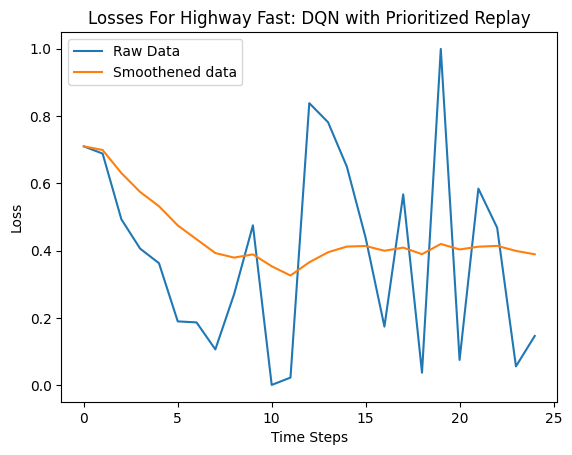

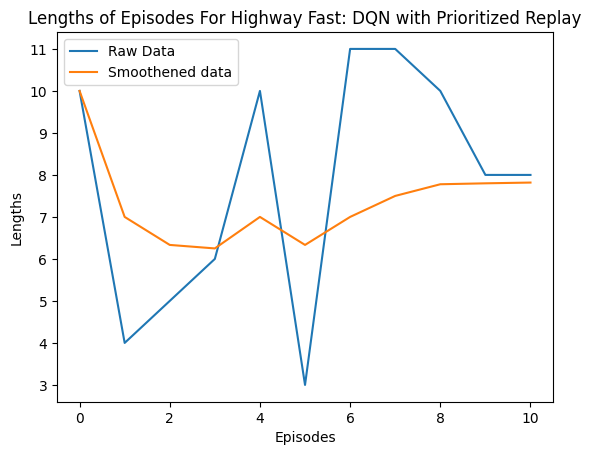

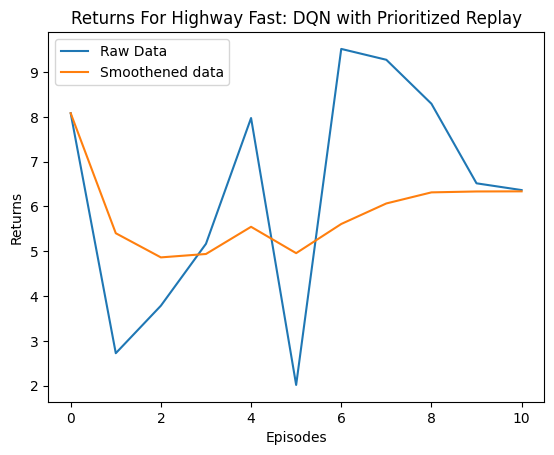

In [255]:
returns_hw = np.load('returns_hwy_dqn_PER_DDQN.npy')
losses_hw = np.load('losses_hwy_dqn_PER_DDQN.npy')
lengths_hw = np.load('lengths_hwy_dqn_PER_DDQN.npy')

plt.plot(losses_hw, label = "Raw Data")
data = moving_average(data = losses_hw, window_size=10000)
plt.plot(data, label = "Smoothened data")
plt.legend()
plt.title("Losses For Highway Fast: DQN with Prioritized Replay")
plt.xlabel("Time Steps")
plt.ylabel("Loss")
plt.show()

plt.plot(lengths_hw, label = "Raw Data")
data = moving_average(data = lengths_hw, window_size=100)
plt.plot(data, label = "Smoothened data")
plt.legend()
plt.title("Lengths of Episodes For Highway Fast: DQN with Prioritized Replay")
plt.xlabel("Episodes")
plt.ylabel("Lengths")
plt.show()

plt.plot(returns_hw, label = "Raw Data")
data = moving_average(data = returns_hw, window_size=1000)
plt.plot(data, label = "Smoothened data")
plt.legend()
plt.title("Returns For Highway Fast: DQN with Prioritized Replay")
plt.xlabel("Episodes")
plt.ylabel("Returns")
plt.show()

### RENDERING HIGHWAY WITH TRAINED DQN

In [256]:
# trained_dqn = dqn_models_highway['100_0']
# episodes = 0
# ep_bar = tqdm.trange(100)
# # while episodes < 1000:
# for ep in ep_bar:
#   done = truncated = False
#   obs, info = env.reset()
#   obs_tensor = torch.tensor(obs).detach()
#   obs_vector = torch.flatten(obs_tensor).to(device)
#   while not (done or truncated):
#     q_values = trained_dqn(obs_vector)
#     max_action = torch.argmax(q_values)
#     obs, reward, done, truncated, info = env.step(max_action)
#     env.render()


## Try decreasing the Replay Buffer size and see if we get faster results. 